# Dog Bites in New York City

Datasets on dog biting incidents compared to dog licenses in New York City. Data courtesy of [DOHMH](https://data.cityofnewyork.us/Health/DOHMH-Dog-Bite-Data/rsgh-akpg) & [NYC Open Data](https://data.cityofnewyork.us/Health/NYC-Dog-Licensing-Dataset/nu7n-tubp).



The goal of this project is to use string identification techniques to categorize dogs into breeds, despite inconsistent breed classifications on behalf of the record takers and pure vs mixed breeds. Another peripheral goal is to practice with different visualization methods in Matplotlib and Seaborn. 



Behind the scenes, I executed a VBA script to isolate breeds and their various inconsistencies (German Shepherd was especially inconsistent in the records. Examples included: "German Shepherd", "German Shepard", "Shepherd", "German Shep", "German Shepherd Dog", and the same goes for all variations for German Shepherd mixes, eventually coded "SHEPHERD MIX").

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
# for dog name wordcloud
from wordcloud import WordCloud
import numpy as np
# for stencils
from PIL import Image
from random import shuffle
import random

df = pd.read_csv('data/Dog_Bite_Data.csv', parse_dates=['DateOfBite'])
df = df[['UniqueID', 'DateOfBite', 'Breed', 'Age', 'Gender', 'SpayNeuter', 'Borough', 'ZipCode', 'CLEANBREED']]

df.head()

df.shape

(8707, 9)

### Bites over time, muscle vs non-muscle

The below code selects rows whose dog's breed is a muscle breed. This is in accordance with the general hypothesis that dogs of certain breeds bite more than others. I considered multiple ways of doing this .loc... this is probably not the best way, but it is pretty fast!

Then, after some Datetime munging, compute a rolling average which will be easier to visualize.

Visualize bites per day under the rolling averages for muscle breeds and non-muscle breeds.

In [2]:
muscle_breeds = ['PIT BULL', 'PIT BULL MIX', 'AMERICAN STAFFORDSHIRE TERRIER', 'STAFFORDSHIRE TERRIER MIX', 'BOXER', 'BOXER MIX',
                'AMERICAN BULLDOG', 'BULLDOG, ENGLISH', 'CANE CORSO', 'CANE CORSO MIX', 'BOXER', 'BOXER MIX',
                'ROTTWEILER', 'ROTTWEILER MIX', 'GERMAN SHEPHERD', 'SHEPHERD MIX']
def in_muscle_breeds(string):
    if string in muscle_breeds:
        return True
    else:
        return False
def reverse(boolean):
    return not boolean
trues = [in_muscle_breeds(x) for x in df['CLEANBREED']]
falses = [reverse(x) for x in trues]
muscle_df = df.loc[trues]
not_muscle_df = df.loc[falses]
not_muscle_df.head()

,UniqueID,DateOfBite,Breed,Age,Gender,SpayNeuter,Borough,ZipCode,CLEANBREED
0,8140,2015-12-02,Pug,7,F,True,Staten Island,NaN,PUG
1,1,2015-01-27,Jack Russ,11,M,False,Brooklyn,11217,JACK RUSS
2,2,2015-01-25,"Mastiff, Bull",NaN,U,False,Brooklyn,NaN,"MASTIFF, BULL"
4,4,2014-12-26,Doberman Pinscher,NaN,M,False,Brooklyn,11204,DOBERMAN PINSCHER
6,6,2015-01-31,CHIHUAHUA MIX,3,M,False,Brooklyn,NaN,CHIHUAHUA MIX


In [3]:
biterdates = muscle_df.loc[(df['DateOfBite']>='2015-01-01')].groupby('DateOfBite').count()['UniqueID']
biterdates.sort_index(inplace=True)
biterdates = pd.DataFrame(biterdates)
biterdates['Rolling mean'] = biterdates['UniqueID'].rolling(window=20).mean()

In [4]:
dates = not_muscle_df.loc[df['DateOfBite']>='2015-01-01'].groupby('DateOfBite').count()['UniqueID']
dates.sort_index(inplace=True)
dates = pd.DataFrame(dates)
dates['Rolling mean'] = dates['UniqueID'].rolling(window=20).mean()

In [5]:
dates2 = not_muscle_df.loc[df['DateOfBite']>'2015-01-01']['DateOfBite'].drop_duplicates()
dates2 = dates2.sort_values()
biterdates2 = muscle_df.loc[df['DateOfBite']>'2015-01-01']['DateOfBite'].drop_duplicates()
biterdates2 = biterdates2.sort_values()

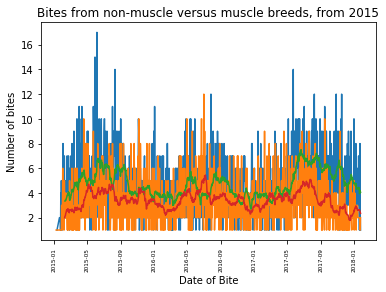

In [7]:
plt.plot(dates2, dates['UniqueID']);
plt.plot(biterdates2, biterdates['UniqueID']);
plt.plot(dates2, dates['Rolling mean']);
plt.plot(biterdates2, biterdates['Rolling mean']);
ticks = plt.xticks(fontsize='xx-small', rotation='vertical')
plt.xlabel('Date of Bite')
plt.ylabel('Number of bites')
plt.title('Bites from non-muscle versus muscle breeds, from 2015');

As we can see, the rolling average of muscle breeds actually outpaces non-muscle breeds at times, especially in summer of 2016. Overall, this is far closer than I anticipated. Also, it's a little curious how the derivative of the moving average of muscle breeds in a way follows that from non-muscle breeds, but a little bit later. Graphing the derivatives side by side would be more revealing.

#### A heatmap of bites, total

Create a seaborn heatmap from a pivot table of bite counts.

In [8]:
df['DateOfBite']=pd.to_datetime(df['DateOfBite'],format='%m/%d/%y')

In [9]:
by_time = df.groupby(df['DateOfBite']).count()['UniqueID']
by_time = pd.DataFrame(by_time)
by_time = by_time.reset_index()
by_time.tail()

,DateOfBite,UniqueID
1106,2018-01-21,3
1107,2018-01-22,7
1108,2018-01-23,10
1109,2018-01-24,3
1110,2018-01-25,3


It seems silly that pandas doesn't have better support than this. But here I make two additional columns to then pivot off of using an aggregate. Select data to result in a balanced shape (some months don't have as much data). 

In [10]:
by_time['Year'] = by_time['DateOfBite'].apply(lambda x: str(x).split('-')[0][-4:])
by_time['Month'] = by_time['DateOfBite'].apply(lambda x: str(x).split('-')[1])
by_time = by_time.loc[(by_time['DateOfBite']>'2015-01-01') & (by_time['DateOfBite']<='2017-12-31')]

In [11]:
pivot = pd.pivot_table(data=by_time, values='UniqueID', index='Month', columns='Year', aggfunc=np.sum)
pivot

Year,2015,2016,2017
Month,,,
01,44,201,183
02,179,172,199
03,214,178,224
04,261,257,232
05,300,261,267
06,290,240,337
07,306,245,344
08,291,271,311
09,254,244,289


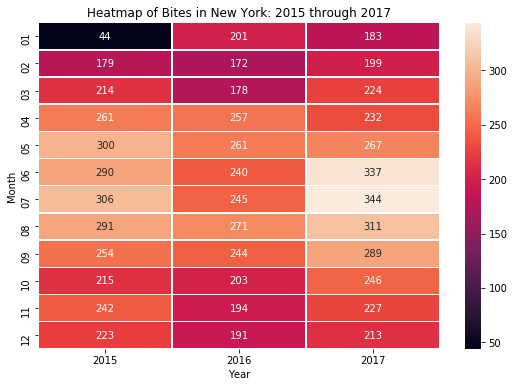

In [12]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(pivot, annot=True, fmt="d", linewidths=.5, ax=ax);
plt.title('Heatmap of Bites in New York: 2015 through 2017');


As we can see, bites seem to be correlated with temperature. It seems likely that dogs are taken for more walks in the warmer weather, and that these walks provide more time around people. July of 2017 saw a nearly 90% increase over the number accumulated in January of the same year.

### Muscle breed prominence in bites vs licenses

Isolate counts of muscle breeds, percentages in both csvs. 

In [13]:
counts = muscle_df["CLEANBREED"].value_counts()
counts_df = pd.DataFrame(counts)
counts_df.head()

,CLEANBREED
PIT BULL,2274
PIT BULL MIX,549
GERMAN SHEPHERD,288
ROTTWEILER,162
SHEPHERD MIX,97


In [14]:
total_dogs = df.count()[0]
counts_df['percentage'] = (counts_df['CLEANBREED'] / total_dogs) * 100
counts_df = counts_df.sort_values('percentage', ascending=False)
counts_df.columns = ["Count", "Percentage"]
counts_df.head()

,Count,Percentage
PIT BULL,2274,26.116917
PIT BULL MIX,549,6.305272
GERMAN SHEPHERD,288,3.307683
ROTTWEILER,162,1.860572
SHEPHERD MIX,97,1.114046


As an aside, look at counts of breeds & sex records.

In [15]:
by_breed = df.groupby(['CLEANBREED', 'Gender'])['UniqueID'].count()
by_breed = by_breed.sort_values(ascending=False)
by_breed.head(5)

CLEANBREED     Gender
PIT BULL       U         1172
               M          749
               F          353
MIXED/UNKNOWN  U          343
PIT BULL MIX   M          320
Name: UniqueID, dtype: int64

In [16]:
licenses = pd.read_csv('data/NYC_Dog_Licensing_Dataset.csv')
licenses.head()

,RowNumber,AnimalName,AnimalGender,AnimalBirthMonth,BreedName,CLEANBOROUGH,Borough,ZipCode,CommunityDistrict,CensusTract2010,NTA,CityCouncilDistrict,CongressionalDistrict,StateSenatorialDistrict,LicenseIssuedDate,LicenseExpiredDate,CLEANBREED
0,533,BONITA,F,5/1/2013 0:00,MIXED/UNKNOWN,QUEENS,Queens,11435.0,412.0,208.0,QN61,28.0,5.0,10.0,10/24/2014,11/15/2017,MIXED/UNKNOWN
1,548,ROCKY,M,5/1/2014 0:00,Labrador Retriever MIX,QUEENS,Queens,11691.0,414.0,100801.0,QN15,31.0,5.0,10.0,10/25/2014,10/25/2019,LABRADOR RETRIEVER MIX
2,622,BULLY,M,7/1/2010 0:00,PIT BULL,QUEENS,Queens,11419.0,410.0,98.0,QN55,28.0,5.0,10.0,10/28/2014,9/24/2016,PIT BULL
3,633,COCO,M,2/1/2005 0:00,Labrador Retriever,QUEENS,Queens,11692.0,414.0,964.0,QN12,31.0,5.0,10.0,10/29/2014,10/29/2017,LABRADOR RETRIEVER
4,655,SKI,F,9/1/2012 0:00,PIT BULL,QUEENS,Queens,11691.0,414.0,100802.0,QN15,31.0,5.0,10.0,10/31/2014,10/31/2019,PIT BULL


In [17]:
licenses_count = licenses.groupby(['CLEANBREED']).count()['RowNumber'].sort_values(ascending=False)
licenses_count.head(5)

CLEANBREED
MIXED/UNKNOWN        16763
YORKSHIRE TERRIER     7773
SHIH TZU              7141
CHIHUAHUA             5771
MALTESE               4292
Name: RowNumber, dtype: int64

As before, isolate muscle breeds from licenses.

In [18]:
trues = [in_muscle_breeds(x) for x in licenses['CLEANBREED']]
muscle_df_licenses = licenses.loc[trues]
counts = muscle_df_licenses["CLEANBREED"].value_counts()
counts_df_licenses = pd.DataFrame(counts)
counts_df_licenses.head()

,CLEANBREED
PIT BULL MIX,3401
PIT BULL,3341
GERMAN SHEPHERD,1886
SHEPHERD MIX,1502
BOXER,1208


Calculate percentages and add column.

In [19]:
total_licensed_dogs = licenses.count()[0]
counts_df_licenses['percentage'] = (counts_df_licenses['CLEANBREED'] / total_licensed_dogs) * 100
counts_df_licenses = counts_df_licenses.sort_values('percentage', ascending=False)
counts_df_licenses.columns = ['Count', 'Percentage']
counts_df_licenses.head()

,Count,Percentage
PIT BULL MIX,3401,2.788871
PIT BULL,3341,2.739670
GERMAN SHEPHERD,1886,1.546548
SHEPHERD MIX,1502,1.231662
BOXER,1208,0.990578


Accumulate data into one DataFrame.

In [20]:
total_counts = counts_df.merge(counts_df_licenses, how='outer', right_index=True, left_index=True)
total_counts.columns = ['Count Bites', 'Pct Bites', 'Count Licenses', 'Pct Licenses']
total_counts = total_counts.sort_values('Pct Bites', ascending=False)
total_counts

,Count Bites,Pct Bites,Count Licenses,Pct Licenses
PIT BULL,2274,26.116917,3341.0,2.739670
PIT BULL MIX,549,6.305272,3401.0,2.788871
GERMAN SHEPHERD,288,3.307683,1886.0,1.546548
ROTTWEILER,162,1.860572,677.0,0.555150
SHEPHERD MIX,97,1.114046,1502.0,1.231662
AMERICAN STAFFORDSHIRE TERRIER,80,0.918801,815.0,0.668312
BOXER,65,0.746526,1208.0,0.990578
CANE CORSO,41,0.470885,235.0,0.192704
BOXER MIX,16,0.183760,36.0,0.029521
ROTTWEILER MIX,8,0.091880,59.0,0.048381


##### Note
Below, the licenses dataframe is trimmed of any rows without proper borough records. Store the resulting set in a new csv. The amount of rows without proper borough designations was about 200, whereas the entire set is over 100 thousand records.

In [254]:
# clean_boroughs = ['QUEENS', 'MANHATTAN', 'STATEN ISLAND', 'BROOKLYN', 'BRONX']
# for i, row in licenses.iterrows():
#     if row['CLEANBOROUGH'] not in clean_boroughs:
#         licenses.drop(index=i, inplace=True)
# licenses['CLEANBOROUGH'].value_counts()
# licenses.to_csv('data/clean_licenses.csv')

In [23]:
licenses = pd.read_csv('data/clean_licenses.csv')

by_borough = licenses.groupby(['CLEANBOROUGH', 'CLEANBREED']).count()['RowNumber']
by_borough.head()

CLEANBOROUGH  CLEANBREED      
BRONX         AFFENPINSCHER        2
              AFGHAN HOUND         3
              AIREDALE TERRIER     1
              AKITA               18
              AKITA MIX            6
Name: RowNumber, dtype: int64

Create a dictionary from the resulting rows of the license set. 

In [24]:
first_dict = by_borough.to_dict()
my_dict = {}
for key in first_dict:
    if key[0] not in my_dict.keys():
        my_dict[key[0]] = {}
        my_dict[key[0]][key[1]] = first_dict[key]
    my_dict[key[0]][key[1]] = first_dict[key]

Get the top biting breeds of the bites set.

In [25]:
bite_breeds = df.groupby(['CLEANBREED']).count()['UniqueID']
num_biting_breeds = bite_breeds.size
sum_biting_breeds = bite_breeds.sum()
top_biters = bite_breeds.sort_values(ascending=False).iloc[0:6]
top_biters
# total_bites_from_top = top_biters.sum()
# total_bites_from_top / 8707

CLEANBREED
PIT BULL           2274
MIXED/UNKNOWN       673
PIT BULL MIX        549
SHIH TZU            359
CHIHUAHUA           341
GERMAN SHEPHERD     288
Name: UniqueID, dtype: int64

##### Top 6 Biting Breeds
There are ~8700 bites in the dataset. 
Although there are 566 breeds & mixes accounted for in the biting set, the top 11 breeds in terms of bites are responsible for over half the bites: 61%, in fact. What's more, just six breeds account for over 50% of bites! We'll take these six breeds and visualize their prominence in the set of licenses. 

In [26]:
biters = ['PIT BULL', 'MIXED/UNKNOWN', 'PIT BULL MIX', 'SHIH TZU', 'CHIHUAHUA', 'GERMAN SHEPHERD']

In [27]:
def color_biters(string):
    if string in biters:
        return 'mediumvioletred'
    else:
        return 'cadetblue'
def in_biters(string):
    if string in biters:
        return True
    else:
        return False

In [28]:
first_group_names = my_dict.keys()
first_group_vals = [licenses.loc[licenses['CLEANBOROUGH']==borough].count()[0] for borough in first_group_names]
first_group_pct = {}

In [29]:
second_group_names = []
second_group_values = []
minitot = 0
bitertot = 0
for borough in first_group_names:
    borough_breeds = my_dict[borough].keys()
    for breed in borough_breeds:
        second_group_names.append(breed)
        breedcount = licenses.loc[(licenses['CLEANBOROUGH']==borough) & (licenses['CLEANBREED']==breed)].count()[0]
        second_group_values.append(breedcount)
        minitot += breedcount
        if breed in biters:
            bitertot += breedcount
    first_group_pct[borough] = bitertot / minitot
    minitot = 0
    bitertot = 0
first_group_pct

{'BRONX': 0.39479736696010787,
 'BROOKLYN': 0.3303568486605819,
 'MANHATTAN': 0.26126654774199604,
 'QUEENS': 0.33030375508251614,
 'STATEN ISLAND': 0.34343343792021513}

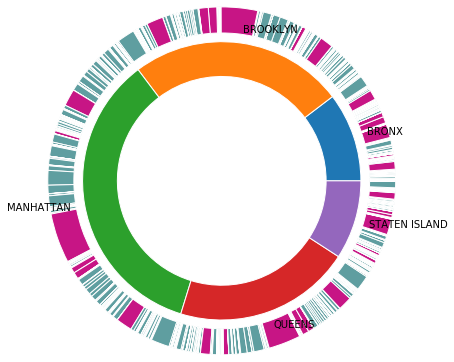

In [30]:
fig, ax = plt.subplots()

ax.set_facecolor('black')

ax.axis('equal')
# mypie, _ = ax.pie(third_group_values, radius=3, colors=third_group_colors)
# plt.setp( mypie, width=0.2, edgecolor='white')

second_group_colors = [color_biters(name) for name in second_group_names]

pie2, _ = ax.pie(second_group_values, radius=2, colors=second_group_colors)
plt.setp( pie2, width=0.3, edgecolor='white')

pie3, _ = ax.pie(first_group_vals, radius=2-0.4, labels=first_group_names)
plt.setp( pie3, width=0.4, edgecolor='white')


# show it
plt.show()

Yeah, the above chart is cool and all, but it doesn't really show the makeup of each borough in terms of biting breeds. More work is required for this one. *

### Most popular dog names per burough

Selecting a list of strings from a DataFrame column (a Series), then constricting them to input into the WordCloud object.

In [31]:
bronx_licenses = licenses.loc[licenses['CLEANBOROUGH']=='BRONX']
bronx_licenses['AnimalName'].head()

921          CJ
2395     SUZZY 
18005     BUDDY
28045       KIM
29824     OREO 
Name: AnimalName, dtype: object

In [32]:
def constrict(array):
    returnstring = ""
    for name in array:
        if (type(name)!=str):
            continue
        else:
            returnstring += name
            returnstring += " "
    return returnstring
bronxnames = constrict(bronx_licenses['AnimalName'].tolist())
manhattannames = constrict(licenses.loc[licenses['CLEANBOROUGH']=='MANHATTAN']['AnimalName'].tolist())
queensnames = constrict(licenses.loc[licenses['CLEANBOROUGH']=='QUEENS']['AnimalName'].tolist())
brooklynnames = constrict(licenses.loc[licenses['CLEANBOROUGH']=='BROOKLYN']['AnimalName'].tolist())
statennames = constrict(licenses.loc[licenses['CLEANBOROUGH']=='STATEN ISLAND']['AnimalName'].tolist())
stopwords = ['MIXED', 'UNKNOWN', 'NAME', 'PROVIDED', 'NOT']


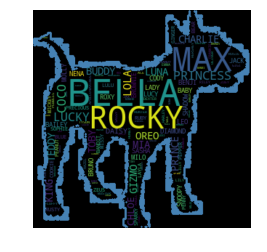

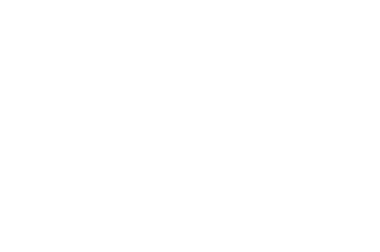

In [33]:
bronxdog = np.array(Image.open("images/terrier_stencil.jpg"))
wc = WordCloud(background_color="black", max_words=2000, mask=bronxdog,
               stopwords=stopwords, contour_width=3, contour_color='steelblue')

wc.generate(bronxnames)

wc.to_file("images/bronx.png")

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.axis("off")
plt.show()

Bella, Rocky, and Max are by far the most popular names. Are there any boroughs where this isn't the case?

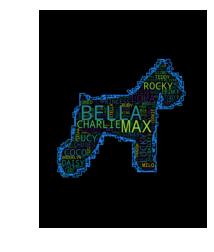

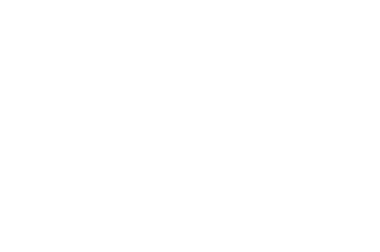

In [34]:
brooklyndog = np.array(Image.open("images/schnauzer_stencil.jpg"))


wc = WordCloud(background_color="black", max_words=1000, mask=brooklyndog,
               stopwords=stopwords, contour_width=3, contour_color='dodgerblue')

wc.generate(brooklynnames)

wc.to_file("images/brooklyn.png")

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.axis("off")
plt.show()

Charlie seems to be pretty popular in Brooklyn. Does Manhattan have any unique name preferences?

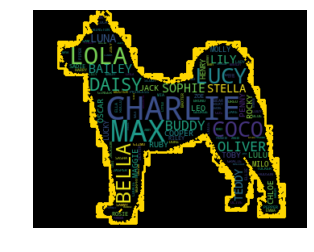

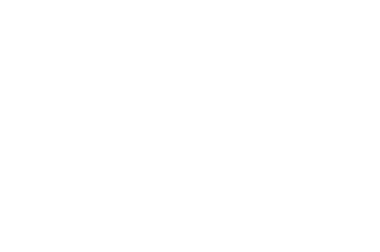

In [35]:
manhattandog = np.array(Image.open("images/akilta_stencil.jpg"))


wc = WordCloud(background_color="black", max_words=500, mask=manhattandog,
               stopwords=stopwords, contour_width=3, contour_color='gold')

wc.generate(manhattannames)

wc.to_file("images/manhattan.png")

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.axis("off")
plt.show()

Charlie seems to be the winner in Manhattan, where Lola and Coco are also very popular. Now, Queens.

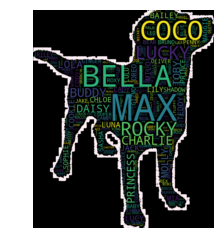

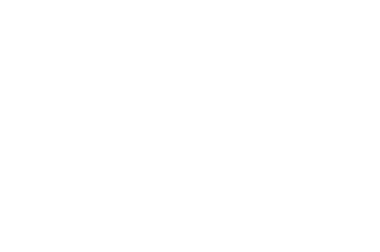

In [36]:
queensdog = np.array(Image.open("images/lab_stencil.jpg"))


wc = WordCloud(background_color="black", max_words=500, mask=queensdog,
               stopwords=stopwords, contour_width=3, contour_color='lavenderblush')

wc.generate(queensnames)

wc.to_file("images/queens.png")

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.axis("off")
plt.show()

Not many unique names here, and the Bronx has very dogs than Manhattan and Brooklyn. The only borough with fewer is Staten Island.

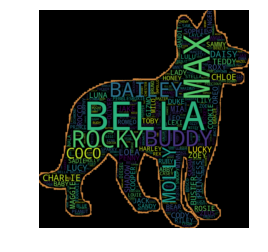

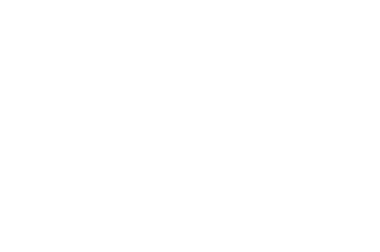

In [37]:
statendog = np.array(Image.open("images/good_dog_stencil.jpg"))


wc = WordCloud(background_color="black", max_words=500, mask=statendog,
               stopwords=stopwords, contour_width=3, contour_color='peru')

wc.generate(statennames)

wc.to_file("images/staten island.png")

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.axis("off")
plt.show()

Bailey, Buddy and Molly appear to be the more popular names in Staten Island, though Bella and Max lead the way.

Same methodology as with earlier, but for muscle breeds.

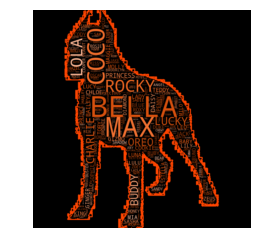

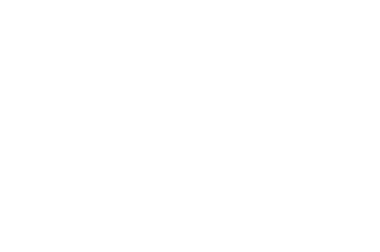

In [38]:
import random

biter_trues = [in_biters(x) for x in licenses['CLEANBREED'].tolist()]
biter_df = licenses.loc[biter_trues]
biternames = constrict(biter_df['AnimalName'].tolist())

biterdog = np.array(Image.open("images/biter_stencil.jpg"))

# Create a function to recolor the word cloud with a specific color.

def red_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(20, 88%%, %d%%)" % random.randint(30, 80)

wc = WordCloud(background_color="black", max_words=500, mask=biterdog,
               stopwords=stopwords, contour_width=3, contour_color='orangered')

wc.generate(biternames)

wc.to_file("images/biternames.png")

plt.imshow(wc.recolor(color_func=red_color_func, random_state=3),
           interpolation="bilinear")

plt.axis("off")
plt.figure()
plt.axis("off")
plt.show()

Of course, these aren't the names of the actual biting dogs whose data we're working with. These are the breeds most likely to bite, and their names across NYC. Therefore, it's unsurprising that we wind up with the same popular names.

### Most popular breeds by burough

Based on the dictionary form of the licenses dataframe, I can tell exactly how many of each breed there are in each borough. Thusly I can make a list of dictionaries, which will be useful for constructing the dataframe, from which I can sort and plot.

In [39]:
bronx_breeds = {"OTHER":0}
for each in my_dict['BRONX'].keys():
    if my_dict['BRONX'][each] >= 100:
        bronx_breeds[each] = my_dict['BRONX'][each]
    else:
        bronx_breeds["OTHER"] += my_dict['BRONX'][each]
bronx_breeds_df = pd.DataFrame.from_dict(bronx_breeds, orient="index").sort_values(0, ascending=False)

In [40]:
bronx_breeds_df.head(7)

,0
OTHER,2621
MIXED/UNKNOWN,1535
YORKSHIRE TERRIER,1236
SHIH TZU,1101
CHIHUAHUA,861
PIT BULL,718
PIT BULL MIX,534


In [41]:
brooklyn_breeds = {"OTHER":0}
for each in my_dict['BROOKLYN'].keys():
    if my_dict['BROOKLYN'][each] >= 100:
        brooklyn_breeds[each] = my_dict['BROOKLYN'][each]
    else:
        brooklyn_breeds["OTHER"] += my_dict['BROOKLYN'][each]
brooklyn_breeds_df = pd.DataFrame.from_dict(brooklyn_breeds, orient="index").sort_values(0, ascending=False)
brooklyn_breeds_df.head(7)

,0
OTHER,4323
MIXED/UNKNOWN,4143
YORKSHIRE TERRIER,2002
SHIH TZU,1892
CHIHUAHUA,1511
PIT BULL MIX,1072
LABRADOR RETRIEVER,959


In [42]:
staten_breeds = {"OTHER":0}
for each in my_dict['STATEN ISLAND'].keys():
    if my_dict['STATEN ISLAND'][each] >= 100:
        staten_breeds[each] = my_dict['STATEN ISLAND'][each]
    else:
        staten_breeds["OTHER"] += my_dict['STATEN ISLAND'][each]
staten_breeds_df = pd.DataFrame.from_dict(staten_breeds, orient="index").sort_values(0, ascending=False)
staten_breeds_df.head(7)

,0
OTHER,3049
MIXED/UNKNOWN,1768
YORKSHIRE TERRIER,738
SHIH TZU,731
LABRADOR RETRIEVER,580
MALTESE,404
PIT BULL MIX,371


In [43]:
queens_breeds = {"OTHER":0}
for each in my_dict['QUEENS'].keys():
    if my_dict['QUEENS'][each] >= 100:
        queens_breeds[each] = my_dict['QUEENS'][each]
    else:
        queens_breeds["OTHER"] += my_dict['QUEENS'][each]
queens_breeds_df = pd.DataFrame.from_dict(queens_breeds, orient="index").sort_values(0, ascending=False)
queens_breeds_df.head(7)

,0
MIXED/UNKNOWN,3651
OTHER,3241
YORKSHIRE TERRIER,1701
SHIH TZU,1568
MALTESE,1171
CHIHUAHUA,1110
LABRADOR RETRIEVER,735


In [44]:
m_breeds = {"OTHER":0}
for each in my_dict['MANHATTAN'].keys():
    if my_dict['MANHATTAN'][each] >= 100:
        m_breeds[each] = my_dict['MANHATTAN'][each]
    else:
        m_breeds["OTHER"] += my_dict['MANHATTAN'][each]
m_breeds_df = pd.DataFrame.from_dict(m_breeds, orient="index").sort_values(0, ascending=False)
m_breeds_df.head(7)

,0
MIXED/UNKNOWN,5640
OTHER,4330
YORKSHIRE TERRIER,2087
CHIHUAHUA,1922
SHIH TZU,1843
LABRADOR RETRIEVER,1661
MALTESE,1217


It is interesting that the Bronx and Brooklyn are more receptive to Pit Bulls and Pit Bull mixes than the other boroughs, who prefer Labrador Retrievers (typically the top ranking large breed).

### Plotting top breeds by borough

To demonstrate the workflow of the plot, we'll use Manhattan as the example sample. 

Use random to shuffle an array of colors generated from plt.cm. 

C:\Users\dariu\Miniconda3\envs\3point6\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


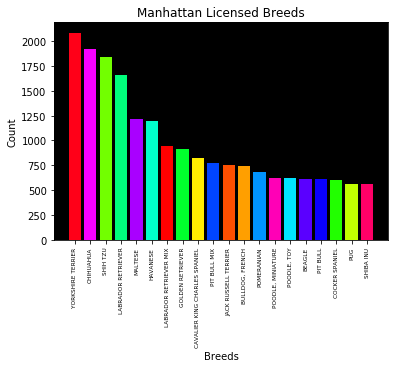

In [52]:
from random import shuffle

m_breeds_df.iloc[0:20, [0]]
labels = []
for row, i in m_breeds_df.iterrows():
    labels.append(i.name)
    
colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired  
cmap = plt.cm.get_cmap("hsv", 20)
colors = [cmap(i) for i in range(20)]
shuffle(colors)

fig = plt.figure()

# iloc goes from 2 to 22 to isolate the 20 most popular breeds, excluding "Mixed" and "Other breeds"

plt.bar(range(20), m_breeds_df.iloc[2:22, 0], color=colors)
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('black')
plt.xlabel("Breeds")
plt.ylabel("Count")
plt.title("Manhattan Licensed Breeds")

# Once again, labels goes from 3rd element to exclude "Mixed", "Other breeds"

_ = plt.xticks(np.arange(20), labels[2:], fontsize='xx-small', rotation='vertical')

### Mixes versus Breeds

To compare mixes to purebreeds in New York, we'll use the pandas Series str contains() function to obtain booleans to .loc from.

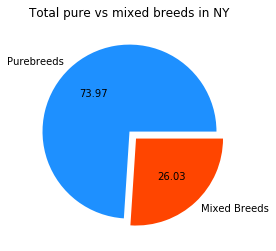

In [53]:
mixes_df = licenses['CLEANBREED'].str.contains('MIX', regex=False).tolist()
i = 0
# for boolean in mixes_df:
#     if type(boolean)!=bool:
#         print(boolean)
#         boolean = False
#         mixes_df[i] = False
#         print(boolean)
#     i += 1

pures = [not elem for elem in mixes_df]
mixes_df = licenses.loc[mixes_df]
pures_df = licenses.loc[pures]

pures_by_breed = pures_df.groupby('CLEANBREED').count()['RowNumber'].sort_values(ascending=False)
mixes_by_breed = mixes_df.groupby('CLEANBREED').count()['RowNumber'].sort_values(ascending=False)
total_licenses = pures_by_breed + mixes_by_breed
plt.pie([int(pures_by_breed.sum()), int(mixes_by_breed.sum())], explode=[0, 0.11], labels=['Purebreeds', 'Mixed Breeds'], colors=['dodgerblue', 'orangered'], autopct='%.2f');
plt.title('Total pure vs mixed breeds in NY');

Use previous .loc selections to display similar percentages, but by borough.

#### Bronx Purebreeds vs Mixes

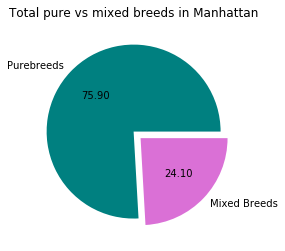

In [54]:
m_licenses = licenses.loc[licenses['CLEANBOROUGH']=='MANHATTAN']

mixes_df = m_licenses['CLEANBREED'].str.contains('MIX', regex=False).tolist()
i = 0
for boolean in mixes_df:
    if type(boolean)!=bool:
        boolean = False
        mixes_df[i] = False
    i += 1

pures = [not elem for elem in mixes_df]
mixes_df = m_licenses.loc[mixes_df]
pures_df = m_licenses.loc[pures]

pures_by_breed = pures_df.groupby('CLEANBREED').count()['RowNumber'].sort_values(ascending=False)
mixes_by_breed = mixes_df.groupby('CLEANBREED').count()['RowNumber'].sort_values(ascending=False)
total_licenses = pures_by_breed + mixes_by_breed
plt.pie([int(pures_by_breed.sum()), int(mixes_by_breed.sum())], explode=[0, 0.11], labels=['Purebreeds', 'Mixed Breeds'], colors=['teal', 'orchid'], autopct='%.2f');
plt.title('Total pure vs mixed breeds in Manhattan');

### Uniqueness & commonness of names by borough

Calculate percentage of totally unique names by borough. Then perform same methodology for common names (0.3% of names or more).

C:\Users\dariu\Miniconda3\envs\3point6\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


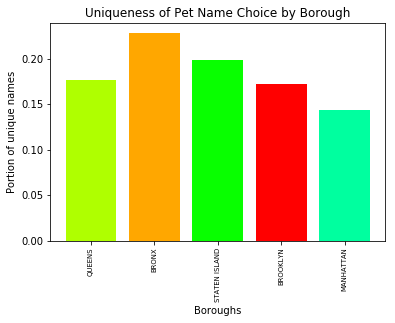

In [55]:
percentages = {}
labels = ['QUEENS', 'BRONX', 'STATEN ISLAND', 'BROOKLYN', 'MANHATTAN']

for each in labels:
    names = pd.DataFrame(licenses.loc[licenses['CLEANBOROUGH']==each].groupby('AnimalName').count()['RowNumber'])
    total_licenses = names.sum()[0]
    
    num_unique = 0
    for row, i in names.iterrows():
        if i[0]==1:
            num_unique += 1
    percentages[each] = num_unique / total_licenses

    
# >>> percentages
# ---------------
# {'QUEENS': 0.17730893950918772,
#  'BRONX': 0.22803812549642574,
#  'STATEN ISLAND': 0.1987075928917609,
#  'BROOKLYN': 0.1725207975703156,
#  'MANHATTAN': 0.1433572183719018}

# Once again, make a random color array.

colormap = plt.cm.gist_ncar
cmap = plt.cm.get_cmap("hsv", 10)
colors = [cmap(i) for i in range(5)]
shuffle(colors)

plt.bar(np.arange(5), [percentages[each] for each in labels], color=colors);
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('black')
plt.ylabel('Portion of unique names')
plt.xlabel('Boroughs')
ticks = plt.xticks(np.arange(5), labels, fontsize='x-small', rotation='vertical')
plt.title('Uniqueness of Pet Name Choice by Borough');

It appears as though the Bronx is the clear leader in terms of name creativity, and Manhattan ranks last.

Do the same, but now for common names. As a rule, I took the top 20 names from Queens and determined the probability of being the 20th most popular name. All names above the proportion get added to the common names. The sum of those common names is divided by total rows, creating another percentage for each borough, plotted as a bar chart.

C:\Users\dariu\Miniconda3\envs\3point6\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


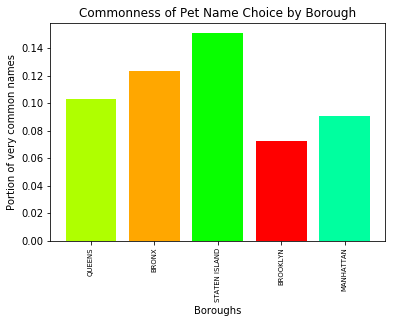

In [56]:
percentages = {}

for each in labels:
    names = pd.DataFrame(licenses.loc[licenses['CLEANBOROUGH']==each].groupby('AnimalName').count()['RowNumber'])
    total_licenses = names.sum()[0]
    
    num_common = 0
    for row, i in names.iterrows():
        if i[0] / total_licenses > 0.003:
            if (row=='NAME NOT PROVIDED') | (row=='MIXED/UNKNOWN'):
                continue
            num_common += i[0]
    percentages[each] = num_common / total_licenses

    
# >>> percentages
# ---------------
# {'QUEENS': 0.10320669362264302,
#  'BRONX': 0.12374900714853058,
#  'STATEN ISLAND': 0.15078082929456113,
#  'BROOKLYN': 0.07232932787534663,
#  'MANHATTAN': 0.09082579584165394}

# Conserve the color array from last time..

plt.bar(np.arange(5), [percentages[each] for each in labels], color=colors);
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('black')
plt.ylabel('Portion of very common names')
plt.xlabel('Boroughs')
ticks = plt.xticks(np.arange(5), labels, fontsize='x-small', rotation='vertical')

plt.title('Commonness of Pet Name Choice by Borough');

Staten Island leads the way here, but not by much. Brooklyn comes in last, with less than 8% of its names falling in the 80th percentile of commonness or greater.

That about wraps this up. Lost interest I suppose. Some of the visuals are unfinished, some of the analyses approximate. But I think the WordClouds with the stencils were awesome, especially that kinda hacky biter_names one. The uniqueness of name graph was kind of fun, too. And that stacked donut chart needs a ton of work. But I'm throwing in the towel. 